In [3]:
import pandas as pd

df = pd.read_csv("concat_data2.csv", na_values=['-'])



In [4]:
# параметры 
s_day =  1 # период сезонности
s_week = 7
s_month = 31
idx_start = -31*4
d = 31
d_day = 1
idx_start_reg = -31*4
idx_end = -d
idx_end_end = -d

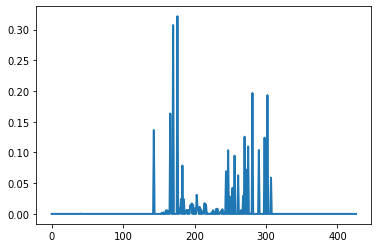

In [5]:
from matplotlib import pyplot as plt
import numpy as np
import random 
import datetime




data = df.iloc[random.choice(range(len(df))), ::]
while data.isnull().values.any():
    data = df.iloc[random.choice(range(len(df))), ::]
        
data = pd.DataFrame(data = {"date":df.columns, "values": data})[1:]
data['date'] = pd.to_datetime(data['date'])


per = data['date'].dt.to_period("d")
data = data.groupby(per)
data_real = data.sum()[:-1]
data = data.mean()[:-1]



plt.plot([i for i in range(len(data))], data, linewidth = 2)
# print(full_test(np_data, 31*5, d, 50, Composition(comp_models)))

In [6]:
train_arr = data[:-3*d]
test_arr = data[-3*d::]

seq_len = d

In [7]:
def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    return x_arr, y_arr

x_train, y_train = transform_data(train_arr, seq_len)
x_test, y_test = transform_data(test_arr, seq_len)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(303, 31) (303, 31)
(62, 31) (62, 31)


In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [10]:
from torch.utils.data import TensorDataset, DataLoader
import torch 

x_train = torch.Tensor(x_train) 
y_train = torch.Tensor(y_train)



In [11]:
import torch.nn as nn

class MyLSTM(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(MyLSTM, self).__init__()

        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )
        last_time_step = \
          lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [12]:
model = model = MyLSTM(
  n_features=1,
  n_hidden=700,
  seq_len=seq_len,
  n_layers=2
)

In [13]:
criterion = torch.nn.MSELoss(reduction='sum')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
num_epochs = 5

In [ ]:
history = []

for i in range(num_epochs):
    model.reset_hidden_state()
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    history.append(loss.item())

    optimizer.step()

    print("epoch {}, loss={}".format(i, loss))
    
model.eval()
        

c:\users\valery\appdata\local\programs\python\python37\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([303, 31])) that is different to the input size (torch.Size([303, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


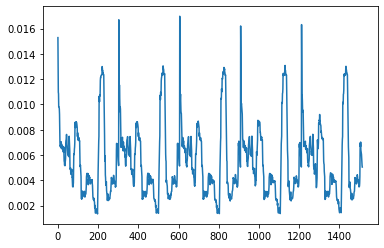

In [57]:

plt.plot(list(range(len(history))), history)